In [57]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

import os
import datetime

In [58]:
# image size
MODEL_INPUT_IMAGE_SIZE = [200, 200]
# Fraction of the dataset to be used for testing. 70% for training 30% for testing
TRAIN_TEST_SPLIT = 0.2
# Number of samples to take from dataset
N = 20000

In [59]:
def parse_image(filename):

    # Read the image from the filename and resize it.
    print(filename)
    image_raw = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, MODEL_INPUT_IMAGE_SIZE) / 255

    # Split the filename to get the age and the gender. Convert the age ( str ) and the gender ( str ) to dtype float32.
    # parts = tf.strings.split(tf.strings.split(filename, '\\')[-1], '_')
    parts = tf.strings.split(filename, '\\')[-2]

    # Normalize
    # age = tf.strings.to_number(parts[0]) // 10
    age = tf.strings.to_number(parts[0]) / 116
    # age = tf.strings.to_number(parts[0]) / 110
    return image, age

source_dir = 'Kaggle'
# part_name = 'mouth'
# part_name = 'nose'
# part_name = 'righteye'
# part_name = 'lefteye'
part_name = 'face'
ext = 'png'
file_path = './{}face/{}/*.{}'.format(source_dir, part_name, ext)

# List all the image files in the given directory.
# list_ds = tf.data.Dataset.list_files('./UTKFace/face/*.jpg', shuffle=True)
# list_ds = tf.data.Dataset.list_files('./UTKFace/mouth/*.png', shuffle=True)
# list_ds = tf.data.Dataset.list_files('./UTKFace/nose/*.png', shuffle=True)
# list_ds = tf.data.Dataset.list_files('./UTKFace/righteye/*.png', shuffle=True)
# list_ds = tf.data.Dataset.list_files('./UTKFace/lefteye/*.png', shuffle=True)


list_ds = tf.data.Dataset.list_files(file_path, shuffle=True)
# list_ds = tf.data.Dataset.list_files('./Kaggleface/mouth/*.png', shuffle=True)
# list_ds = tf.data.Dataset.list_files('./Kaggleface/nose/*.png', shuffle=True)
# list_ds = tf.data.Dataset.list_files('./Kaggleface/righteye/*.png', shuffle=True)
# list_ds = tf.data.Dataset.list_files('./Kaggleface/lefteye/*.png', shuffle=True)

# Map `parse_image` method to all filenames.
dataset = list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.take(N)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ./Kaggleface/face/*.png'

In [ ]:
# Create train and test splits of the dataset.
num_examples_in_test_ds = int(dataset.cardinality().numpy() * TRAIN_TEST_SPLIT)

test_ds = dataset.take(num_examples_in_test_ds)
train_ds = dataset.skip(num_examples_in_test_ds)

print('Num examples in train ds {}'.format(train_ds.cardinality()))
print('Num examples in test ds {}'.format(test_ds.cardinality()))

Num examples in train ds 7632
Num examples in test ds 1907


In [ ]:
# Negative slope coefficient for LeakyReLU.
leaky_relu_alpha = 0.2

lite_model = False

output_size = 1

# Define the conv block.
def conv(x, num_filters, kernel_size=(3, 3), strides=1):
    if lite_model:
        x = tf.keras.layers.SeparableConv2D(num_filters,
                                            kernel_size=kernel_size,
                                            strides=strides, 
                                            use_bias=False,
                                            kernel_initializer=tf.keras.initializers.HeNormal(),
                                            kernel_regularizer=tf.keras.regularizers.L2(1e-5)
                                            )(x)
    else:
        x = tf.keras.layers.Conv2D(num_filters ,
                                   kernel_size=kernel_size ,
                                   strides=strides,
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.HeNormal() ,
                                   kernel_regularizer=tf.keras.regularizers.L2(1e-5)
                                   )(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(x)
    return x

def dense(x, filters, dropout_rate):
    x = tf.keras.layers.Dense(filters, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


# No. of convolution layers to be added.
num_blocks = 6
# Num filters for each conv layer.
num_filters = [16, 32, 64, 128, 256, 256]
# # Kernel sizes for each conv layer.
# kernel_sizes = [3, 3, 3, 3, 3, 3]

# Init a Input Layer.
inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [3])

# Add conv blocks sequentially
x = inputs
for i in range(num_blocks):
    # x = conv(x, num_filters=num_filters[i], kernel_size=kernel_sizes[i])
    x = conv(x, num_filters=num_filters[i])
    x = tf.keras.layers.MaxPooling2D()(x)

# Flatten the output of the last Conv layer.
x = tf.keras.layers.Flatten()(x)
conv_output = x 

# Add Dense layers ( Dense -> LeakyReLU -> Dropout )
x = dense(conv_output, 256, 0.6)
x = dense(x, 64, 0.4)
x = dense(x, 32, 0.2)
outputs = tf.keras.layers.Dense(output_size , activation='relu')(x)

# Build the Model
model = tf.keras.models.Model(inputs , outputs)

# Uncomment the below to view the summary of the model.
model.summary()
# tf.keras.utils.plot_model( model , to_file='architecture.png' )

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 198, 198, 16)      432       
                                                                 
 batch_normalization_18 (Bat  (None, 198, 198, 16)     64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 198, 198, 16)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 97, 97, 32)        4608

In [ ]:
# leaky_relu_alpha = 0.2
# lite_model = False
# output_size = 1

# def conv2D(x, num_filters, kernel_size=(3, 3), strides=1):
#     x = tf.keras.layers.Conv2D(num_filters ,
#                                 kernel_size=kernel_size ,
#                                 strides=strides,
#                                 use_bias=False,
#                                 kernel_initializer=tf.keras.initializers.HeNormal() ,
#                                 kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(x)
#     return x

# def dense(x, filters, dropout_rate):
#     x = tf.keras.layers.Dense(filters, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
#     x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
#     return x

# cov_filters = [32, 64, 128, 256, 256]
# dense_filters = [128, 64, 32]
# dropout_filters = [0.3, 0.3, 0.2]


# inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [3])

# # Add conv blocks sequentially
# x = inputs
# # print(len(cov_filters))
# for i in range(len(cov_filters)):
#     x = conv2D(x, num_filters=cov_filters[i])
#     x = tf.keras.layers.MaxPooling2D()(x)

# # Flatten the output of the last Conv layer.
# x = tf.keras.layers.Flatten()(x)
# # conv_output = x 

# # Add Dense layers ( Dense -> LeakyReLU -> Dropout )
# for i in range(len(dense_filters)):
#     x = dense(x, dense_filters[i], dropout_filters[i])
    
# outputs = tf.keras.layers.Dense(output_size , activation='relu')(x)

# # Build the Model
# model = tf.keras.models.Model(inputs , outputs)

# # Uncomment the below to view the summary of the model.
# model.summary()

In [ ]:
# Initial learning rate
learning_rate = 0.001

num_epochs = 50
batch_size = 128

patience = 10

# Batch and repeat `train_ds` and `test_ds`.
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Init ModelCheckpoint callback
save_dir_ = 'model_1'
save_dir = save_dir_ + '/{epoch:02d}-{val_mae:.2f}.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( 
    save_dir,
    save_best_only=True,
    monitor='val_mae',
    mode='min'
)

# Init LR Scheduler
def scheduler( epochs , learning_rate ):
    if epochs < num_epochs * 0.25:
        return learning_rate
    elif epochs < num_epochs * 0.5:
        return 0.0005
    elif epochs < num_epochs * 0.75:
        return 0.0001
    else:
        return 0.000095

lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Init Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=patience)

# Compile the model
model.compile( 
    loss=tf.keras.losses.mean_absolute_error,
    optimizer = tf.keras.optimizers.Adam(learning_rate), 
    metrics=['mae']
)

In [ ]:
model.fit( 
    train_ds,
    epochs=num_epochs,
    validation_data=test_ds,
    callbacks=[checkpoint_callback, lr_schedule_callback, early_stopping_callback]
)

Epoch 1/50
60/60 [==============================] - 19s 270ms/step - loss: 22.0811 - mae: 0.2563 - val_loss: 8.9653 - val_mae: 0.1840 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 12s 194ms/step - loss: 4.5951 - mae: 0.1489 - val_loss: 1.9957 - val_mae: 0.1565 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 12s 191ms/step - loss: 1.1604 - mae: 0.1242 - val_loss: 0.6829 - val_mae: 0.1540 - lr: 0.0010
Epoch 4/50
60/60 [==============================] - 12s 191ms/step - loss: 0.4590 - mae: 0.1187 - val_loss: 0.3586 - val_mae: 0.1535 - lr: 0.0010
Epoch 5/50
60/60 [==============================] - 12s 191ms/step - loss: 0.2566 - mae: 0.1129 - val_loss: 0.2277 - val_mae: 0.1303 - lr: 0.0010
Epoch 6/50
60/60 [==============================] - 12s 191ms/step - loss: 0.1836 - mae: 0.1074 - val_loss: 0.1757 - val_mae: 0.1156 - lr: 0.0010
Epoch 7/50
60/60 [==============================] - 12s 190ms/step - loss: 0.1550 - mae: 0.1023 - val_loss: 0.1702 - val_ma

In [ ]:
model.save('model/{}/model_age_{}_{}.h5'.format(source_dir, part_name, source_dir))

In [ ]:
p = model.evaluate(test_ds)
print(p)

15/15 [==============================] - 2s 95ms/step - loss: 0.0750 - mae: 0.0434
[0.07499338686466217, 0.04335549846291542]


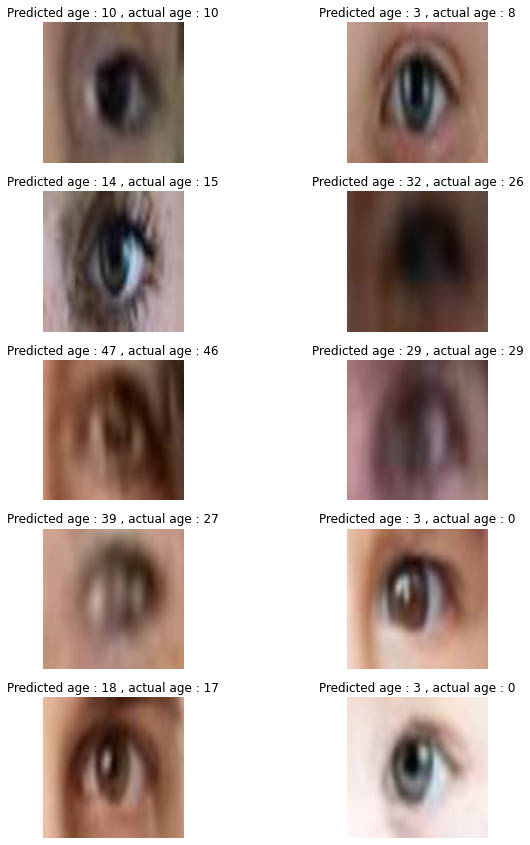

In [ ]:
fig = plt.figure( figsize=( 10 , 15 ) )
rows = 5
columns = 2

i = 1
for image , label in test_ds.unbatch().take( 10 ):
    image = image.numpy()
    fig.add_subplot( rows , columns , i )
    plt.imshow( image )
    label_ = int( model.predict( np.expand_dims( image , 0 ) ) * 116 )
    plt.axis( 'off' )
    plt.title( 'Predicted age : {} , actual age : {}'.format( label_ , int( label.numpy() * 116 ) ) )
    i += 1
    
plt.savefig('image/{}/output_{}_{}.png'.format(source_dir, part_name, source_dir))

In [ ]:
predict = []
actual = []
for image , label in test_ds.unbatch():
    image = image.numpy()
    label_ = int( model.predict( np.expand_dims( image , 0 ) ) * 116 )
    predict.append(label_)
    actual.append(int( label.numpy() * 116 ))
print(len(predict), len(actual))

import pandas as pd

df = pd.DataFrame(data={
    'predict': predict,
    'actual': actual
})

df

1907 1907


,predict,actual
0,45,75
1,3,1
2,24,26
3,62,58
4,3,1
...,...,...
1902,41,23
1903,49,62
1904,45,58
1905,66,69


In [ ]:
df.to_csv('result_csv/{}/model_age_{}_result_{}.csv'.format(source_dir, part_name, source_dir))